## 회귀 실습 - 캐글 주택 가격 

데이터 다운로드  
https://www.kaggle.com  
house 검색  
train.csv  다운로드 받아서 house_price.csv로 저장

- https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

house_price 데이터 
- 79개의 변수로 구성
- 미국 아이오와 주의 에임즈(Ames) 지방의 주택 가격 정보 데이터

성능 평가는 RMSLE(Root Mean Squared Log Error) 기반

- 가격이 비싼 주택일수록
- 예측 결과 오류가 전체 오류에 미치는 비중이 높으므로
- 이것을 상쇄하기 위해 오류값을 로그 변환한 RMSLE 이용
- RMSE를 하되 예측값과 실제값의 로그 변환값을 기반으로
- RMSE 수행 (RMSLE와 동일 방식)

전체 회귀 분석 과정
- 데이터 전처리
    - 단계별로 전처리 수행
    - 원본 보관 후 copy본으로 사용하는것이 일반적
- 선형 회귀 모델 학습/예측/평가
- 회귀 트리 모델 학습/예측/평가
- 회귀 모델의 예측 결과 혼합을 통한 최종 예측
- 스태킹 앙상블 모델을 통한 회귀 예측

### 데이터 전처리

In [102]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('./data/house_price.csv')
house_df = house_df_org.copy()
house_df.head()
house_df.tail()
# Target 값 : SalePrice (마지막 칼럼)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


### 주요 피처들
- https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

- 1stFlrSF: First Floor square feet  
- 2ndFlrSF: Second floor square feet  
- GrLivArea: Above grade (ground) living area square feet  # 거실면적   
- Bedroom: Bedrooms above grade (does NOT include basement bedrooms)  
- LotArea: Lot size in square feet # 대지크기에 따른 건평   
- GarageArea: Size of garage in square feet   # 차고크기 
- YearBuilt: Original construction date 
- OverallQual: Rates the overall material and finish of the house  
       10	Very Excellent  
       9	Excellent  
       8	Very Good  
       7	Good  
       6	Above Average  
       5	Average  
       4	Below Average  
       3	Fair  
       2	Poor  
       1	Very Poor	

In [103]:
# 데이터 확인
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

**데이터 타입과 Null 값 갯수 확인**

In [104]:
print('데이터 세트의 Shape:',house_df.shape)
# 타겟값과 일련번호 제외 79개의 특성
print('\n전체 feature 들의 type \n',house_df.dtypes.value_counts())
# object형은 범주형 변수이므로 수치화하는 작업을 진행해야 함
# 더미변수변수나 라벨인코딩등의 방법을 사용해야 함
# 회귀에서는 더미변수화를 일단 진행함-특성이 너무 늘어나면 피처압축을 
# 진행하는것을 고려해봐야 함

# Null 컬럼 확인 : Null이 있는 컬럼과 그 건수를 내림차순으로 출력
is_null_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', is_null_series[is_null_series>0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 컬럼과 그 건수:
  PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


#### 결과
- 피처 타입 : 숫자형, 문자형(43개)
- Null값이 1000개 이상인 데이터도 있음(drop)

### 회귀 모델 적용하기 전에 타겟 값의 분포도 확인

- SalesPrice의 분포도 확인

<AxesSubplot:title={'center':'Original Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

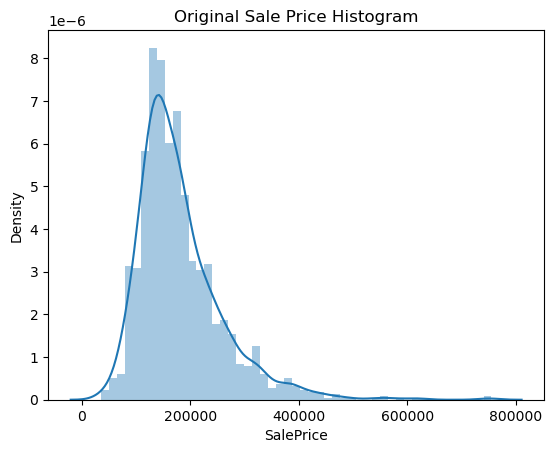

In [105]:
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

- 데이터의 분포가 중심에서 왼쪽으로 치우친 형태
    - 정규 분포에서 벗어나 있음

로그 변환 및 환원
- 정규 분포가 아닌 결과값을 정규 분포 형태로 변환
- log1p() 이용해 로그 변환한 결과값을 기반으로 학습한 후
- 예측 시에는 다시 결과값을 expm1()으로 환원

<AxesSubplot:title={'center':'Log Transformed Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

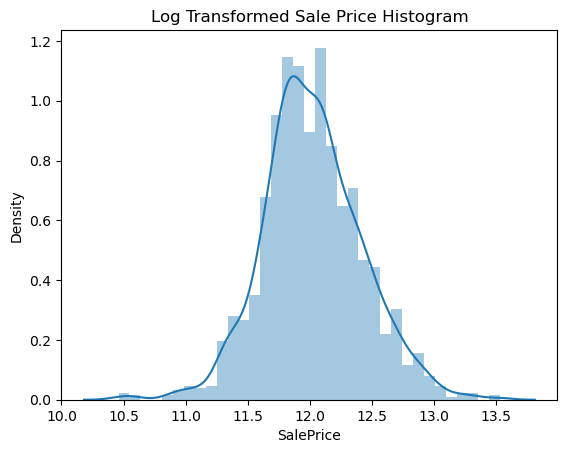

In [106]:
# 결과값을 로그 변환하고 다시 분포도 확인
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

### 전처리 진행
- **타겟값인 Price를 로그변환하고 피처들 중 숫자형 컬럼의 Null값 데이터 처리**

In [107]:
# SalePrice 로그 변환
 #원래값 저장
 #로그변환 값으로 타겟값을 대체
original_SalePrice = house_df['SalePrice']
house_df['SalePrice']=np.log1p(house_df['SalePrice'])

In [108]:
#Null이 너무 많은 컬럼들과 불필요한 컬럼 삭제
# house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1,inplace=True)
house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence'],axis=1,inplace=True)

In [109]:
# drop하지 않은 숫자형 Null 컬럼들은 평균값으로 대체
# 컬럼의 대표값으로 결측치를 채울때 범주형변수는 빈도수, 연속형변수는 평균값을 이용
house_df.fillna(house_df.mean(),inplace=True)
# 평균계산이 가능한 컬럼에 대해서만 결측치 처리

In [110]:
# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
# print(null_column_count.index)
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])
# 범주형 변수에만 null값이 있음
# 범주형 변수의 결측치는 결측 자체를 하나의 범주로 처리할 수 있음
# -> null 그대로 두고 더미변수를 생성

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
FireplaceQu     object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


**문자열값은 모두 카테고리값. 판다스의 get_dummies( )를 이용하여 원-핫 인코딩 수행**

In [111]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape )
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:',house_df_ohe.shape )

get_dummies() 수행 전 데이터 Shape: (1460, 76)
get_dummies() 수행 후 데이터 Shape: (1460, 276)


In [112]:
null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('## Null 피처의 Type :\n', null_column_count)

## Null 피처의 Type :
 Series([], dtype: int64)


### 선형 회귀 모델의 학습/예측/평가

LinearRegression, Ridge, Lasso를 이용해 선형 계열의 회귀 모델 만들기

**RMSE 평가 함수 생성**

In [113]:
# 단일 모델의 RMSE 값 반환
def get_rmse(model): # 학습된 모델을 받아서 예측
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 여러 모델의 RMSE 값 반환
def get_rmses(models) :
    rmses = []
    for model in models :        
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [114]:
## 데이터 분할
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 타깃과 피처
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

**모델 학습/예측/평가ㅣ**

In [115]:
# 일반 선형 회귀
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
# 릿찌회귀
ridge_reg = Ridge()
ridge_reg.fit(X_train,y_train)
# 라쏘 회귀
lasso_reg = Lasso()
lasso_reg.fit(X_train,y_train)

Lasso()

In [116]:
#학습된 모델 전달하고
# rmse값 반환
models=[lr_reg, ridge_reg, lasso_reg]
get_rmses(models)#학습된 모델 전달하고
# rmse값 반환

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.13216855492767474, 0.12821247260035262, 0.17628250556471395]

### 결과
- 라쏘회귀가 타 회귀 방식보다 상대적으로 성능이 떨어진다
- 하이퍼 파라미터 튜닝이 필요(alpha 하이퍼파라미티에 대해서 최적화 수행)

**회귀 계수의 시각화**

- 변수가 많으므로 상위10개 하위 10개의 피처명과 회귀계수값을 반환하는 함수를 작성해서 사용

In [117]:
# 회귀계수값 상하 10등에 해당하는 변수,회귀계수 시리즈 반환
def get_top_bottom_coef(model) :
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    
    return coef_high, coef_low

In [118]:
# 모델별 회귀 계수 시각화 함수
# list 객체로 모델을 입력 받아서
# 모델별로 회귀 계수 상위 10개, 하위 10개 추출해서
# 가로 막대 그래프 형태로 출력
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__ +' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120) # 안쪽, 패딩값
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

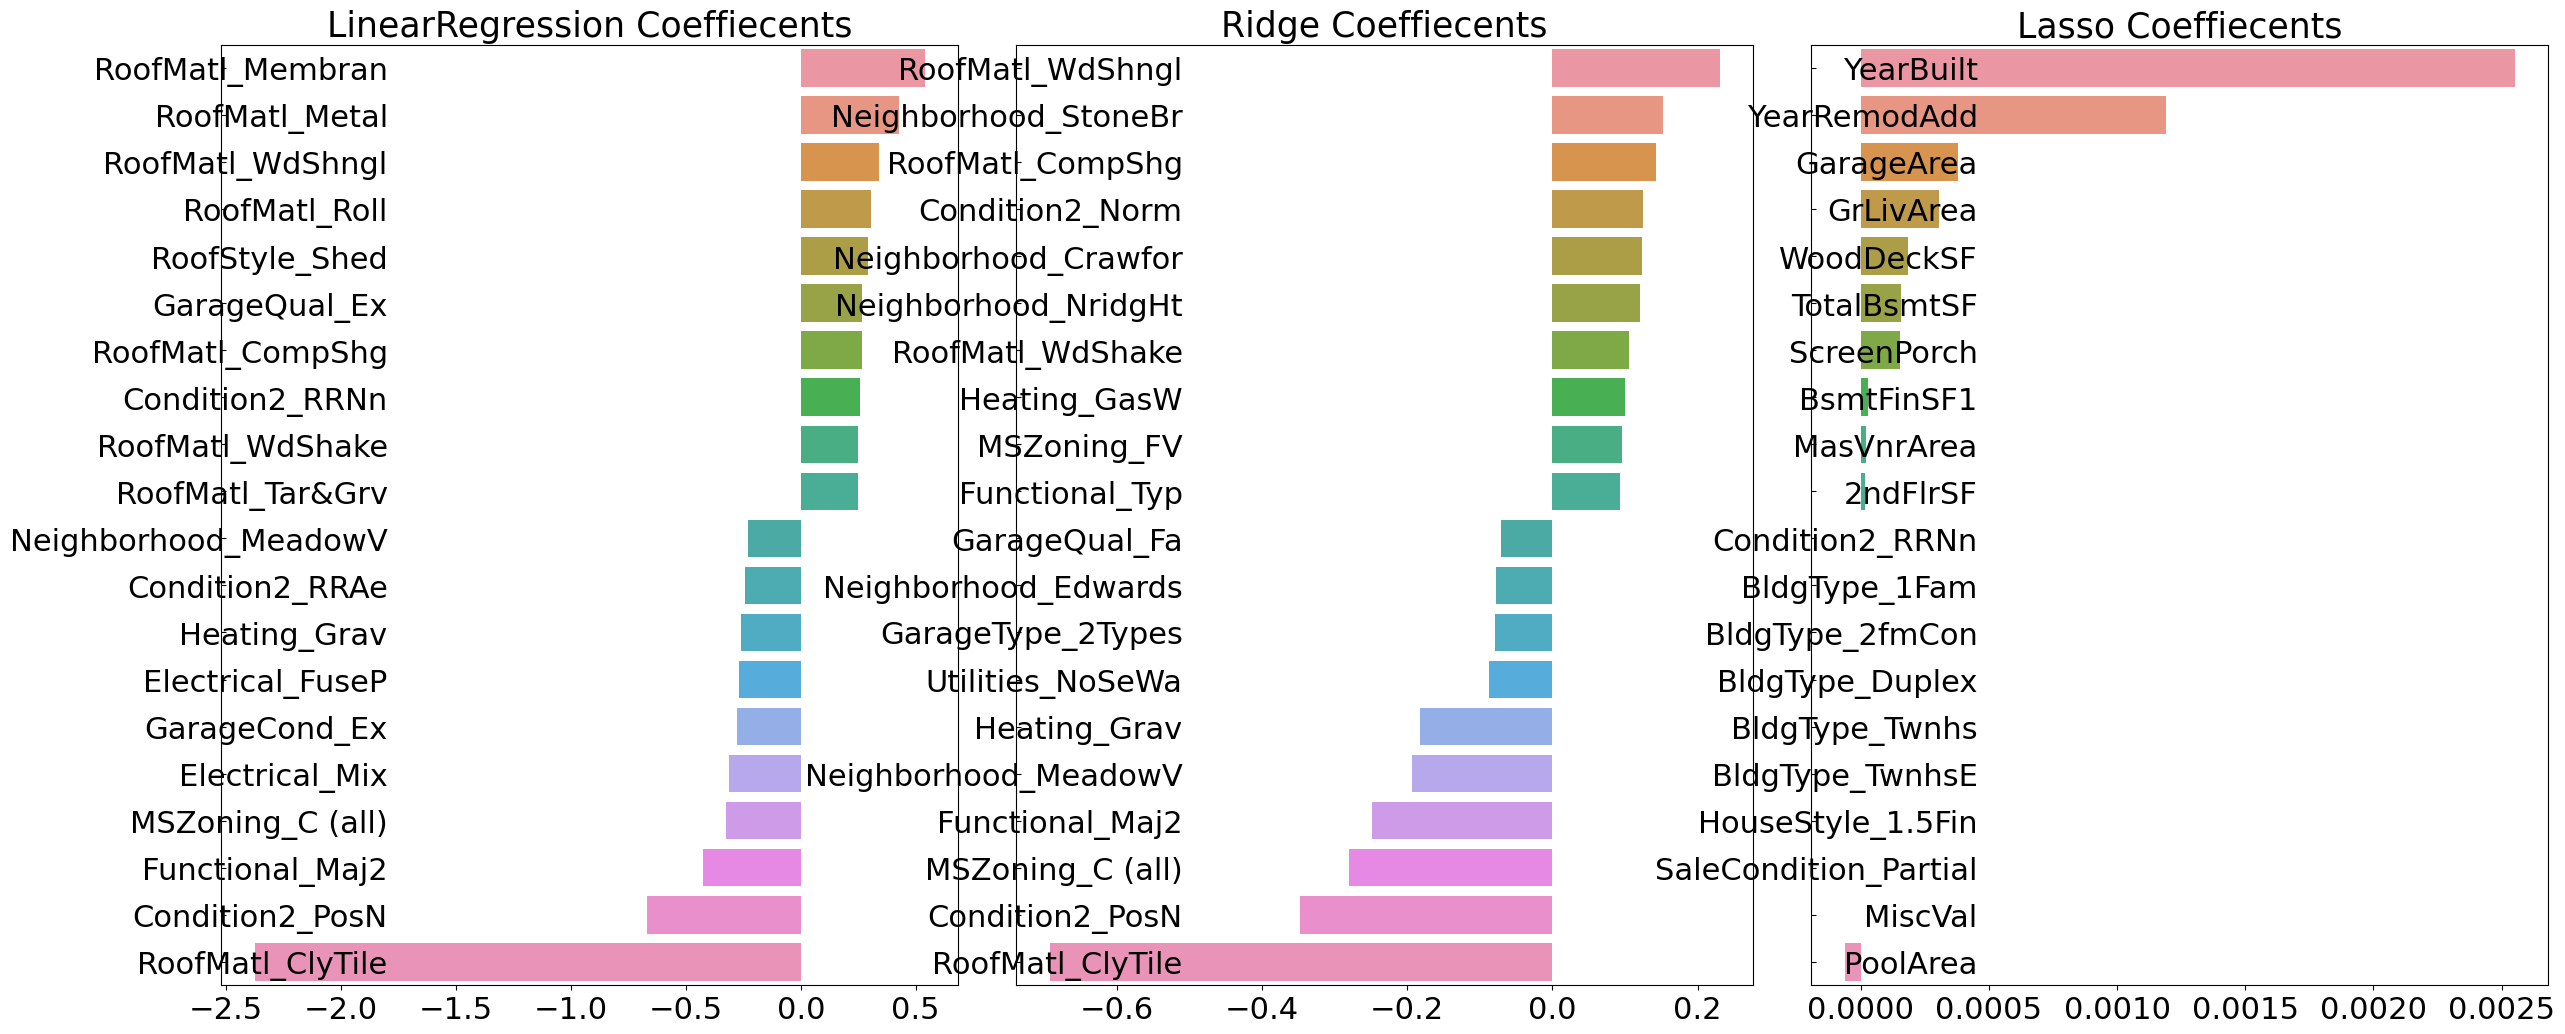

In [119]:
# 앞에서 학습한 3개 모델에 대해 시각화
models = [lr_reg,ridge_reg,lasso_reg]
visualize_coefficient(models)

In [120]:
# 결과
# OLS 기반의 LinearRegression과 Ridge : 회귀 계수가 유사한 형태로 분포
# 라쏘 : 전체적으로 회귀 계수 값이 매우 작음.
#       - Year Built가 가장 크고, 다른 피처의 회기 계수는 너무 작음
#       - LinearRegression과 Ridge와 다른 회귀 계수 형태
# --> 혹시 학습 데이터의 분할에 문제가 있어서 그런 것인지
# 학습과 테스트 데이터 세트를 train_test_split()으로 분할하지 않고
# 전체 데이터 세트인 X_features와 y_target을 5개의 교차 검증 폴드 세트로 분할해서
# 평균 RMSE 측정
# 현재 데이터에 대해서 모델의 성능을 한번 추정해 보자


**5 폴드 교차검증으로 모델별로 RMSE와 평균 RMSE 출력**
- 함수 생성

In [121]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models) :    
    for model in models :
        # 분할하지 않고 전체 데이터세트로 교차검증 수행
        rmse_list = np.sqrt(-cross_val_score(model,
                                            X_features,
                                            y_target,
                                            scoring="neg_mean_squared_error",
                                            cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))        

In [122]:
# X_features
# y_target

In [123]:
# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력           
models=[lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [1.36000e-01 2.39446e+03 1.67000e-01 1.11000e-01 1.97000e-01]
LinearRegression CV 평균 RMSE 값: 479.014

Ridge CV RMSE 값 리스트: [0.118 0.156 0.142 0.117 0.188]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


### 결과
- 5개 폴드 세트로 학습한 후 평가해도
    - 여전히 라쏘 모델이 다른 회귀 모델에 비해 성능이 떨어짐

**리지/라쏘 모델에 대해 alpha 하이퍼파라미터 튜닝 후 재학습/예측/평가**

In [124]:
from sklearn.model_selection import GridSearchCV
# 모델과 하이퍼 파라미터 딕셔너리 객체를 받아서
# 최적화 작업의 결과를 표시하는 함수
# GridSearchCV이용해서 하이퍼파라미터 튜닝하고 최적 하이퍼파리미터값 출력
# 릿지 모델과 라쏘 모델의 최적화 alpha 값 추출
# 베스트모델 반환하는 함수
def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error',cv=5)
    grid_model.fit(X_features, y_target) 
    rmse=np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_# 최적 파라미터로 재학습된 모델 반환

In [125]:
# ridge의 alpha값은 상대적으로 lasso보다는 크게 설정한다
# 규제 기준값의 크기 차이가 ridge가 훨씬 큰값이다
ridge_params = {'alpha' : [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005, 0.008,0.05, 0.03, 0.1, 0.5, 1.5,10]}

In [126]:
best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 RMSE 값: 0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 RMSE 값: 0.142, 최적 alpha:{'alpha': 0.001}


### 결과
- 릿지 모델 : alpha가 12에서 최적 RMSE 가 0.1418
- 라쏘 모델 : alpha가 0.001에서 최적 RMSE가 0.142
- **라쏘 : alpha 최적화한 후 예측성능이 향상 됨(0.198->0.142)**

### 찾아낸 최적 alpha값 이용해서 재 학습
- **분할된 트레인 테스트 데이터를 이용해 학습 후 평가**

In [127]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.001)

In [128]:
# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.125
Lasso 로그 변환된 RMSE: 0.12


[0.13216855492767474, 0.12457283420435002, 0.12037308561703283]

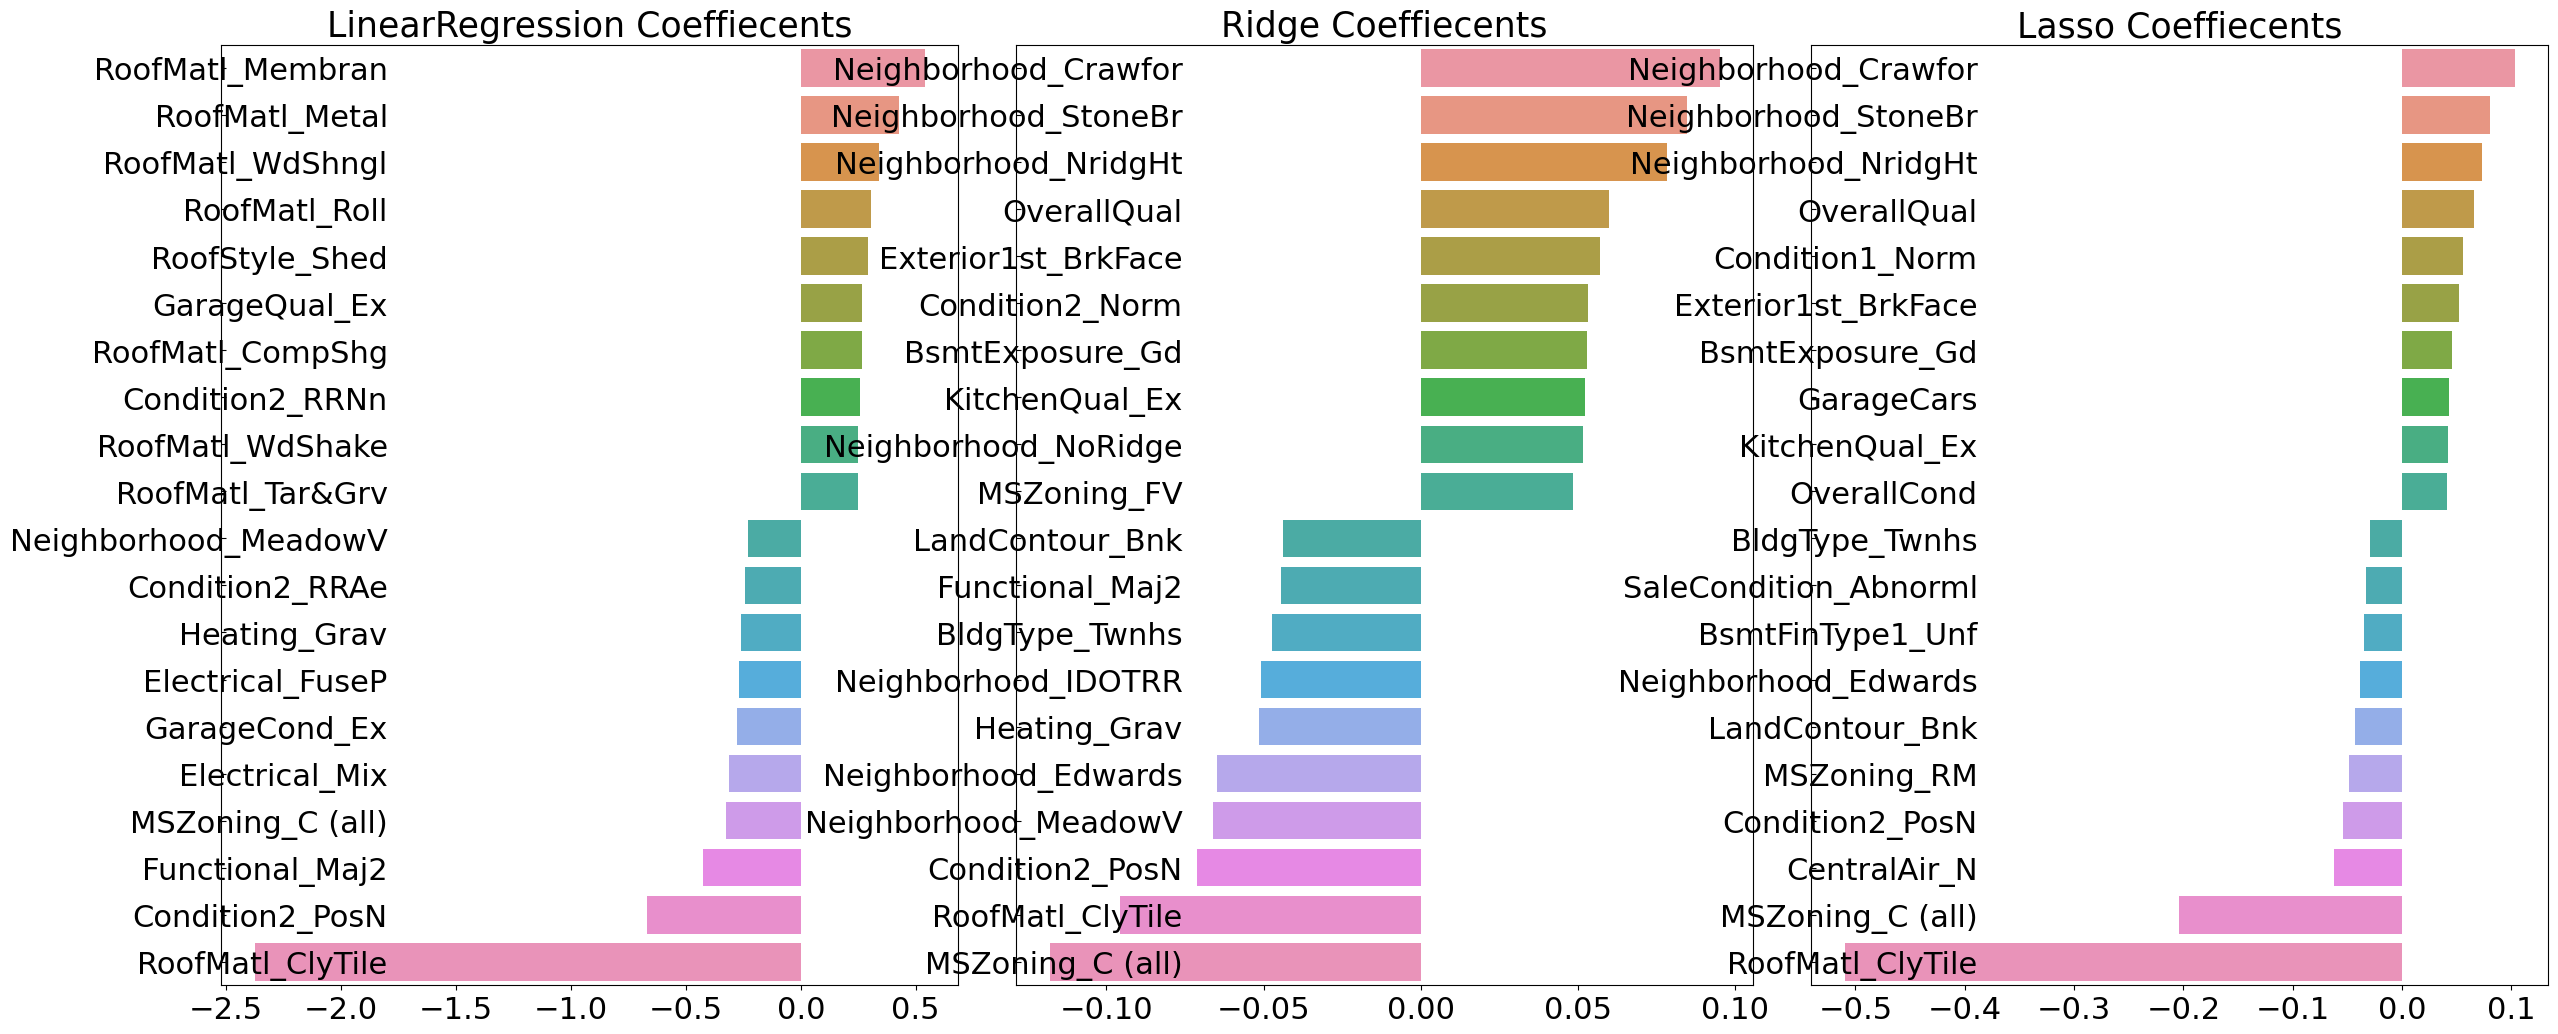

In [129]:
# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 데이터 세트를 추가적으로 가공해서 모델 튜닝을 좀 더 진행 
#### 두번째 전처리 추가(데이터의 왜곡과 이상치를 파악해서 해결)
1. 피처 데이터 세트의 데이터 분포도 확인
2. 이상치 데이터 처리

##### 왜곡된 정도 추출 
- 모든 변수를 그래프로 확인 할 수 없으므로 
    - skew() 함수 사용
    - **주의. 숫자형 피처에서 원-핫 인코딩된 카테고리 숫자형 피처 제외**

In [130]:
from scipy.stats import skew
# 숫자형 피처에서 원-핫 인코딩된 카테고리 숫자형 피처 제외
feautres_index = house_df.dtypes[house_df.dtypes != 'object'].index

In [131]:
feautres_index

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [132]:
# skew() 는 컬럼이나 로우별로 진행해 주지 않음
# 컬럼별 skew() 계산하기 위해 apply 함수 사용
skew_features = house_df[feautres_index].apply(lambda x : skew(x))

In [133]:
# skew_features

In [134]:
#skew 정도가 1초과인  컬럼들만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))
# 일반적으로 skew() 함수의 반환값이 1이상인 경우 왜곡도가 높다고 판단하지만
# 상황에 따라 편차는 있음

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


##### 왜곡이 심한 컬럼에 로그변환 후 재학습/예측/평가

In [135]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [136]:
# 로그 변환 후 다시 왜곡 정도를 확인해 보면
skew_features = house_df[feautres_index].apply(lambda x : skew(x))
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

# 여전히 왜곡 정도가 높은 피처가 있지만 더이상 로그변환 하더라도 개선하기 어렵다고 판단
# 그대로 유지하기로 결정

PoolArea         14.348342
3SsnPorch         7.727026
LowQualFinSF      7.452650
MiscVal           5.165390
BsmtHalfBath      3.929022
KitchenAbvGr      3.865437
ScreenPorch       3.147171
BsmtFinSF2        2.521100
EnclosedPorch     2.110104
dtype: float64


In [139]:
# Skew가 높은 피처들을 로그 변환 했으므로 
# 다시 원-핫 인코딩 적용 
# 피처/타겟 데이터 세트 다시 생성
# 최적 alpha 값과 RMSE 출력

# 원-핫 인코딩
house_df_ohe = pd.get_dummies(house_df)
# 피처/타겟 데이터 세트 다시 생성# 
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

In [140]:
# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = get_best_params(ridge_reg,ridge_params)
best_lasso = get_best_params(lasso_reg,lasso_params)

Ridge 5 CV 시 최적 RMSE 값: 0.1277, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 RMSE 값: 0.1253, 최적 alpha:{'alpha': 0.001}


In [141]:
# 수치데이터에 대해 로그변환된 새로운 데이터로 재학습
# 분할된 학습/테스트 데이터를 이용해서
# 모델의 학습/예측/평가 및 모델별 회귀 계수 시각화

# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.001)

In [142]:
# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
# 독립변수 중 수치형 데이터를 로그변환 후 성능이 향상되었음

LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.123
Lasso 로그 변환된 RMSE: 0.119


[0.1287771904479168, 0.12318819323857069, 0.11949942324983102]

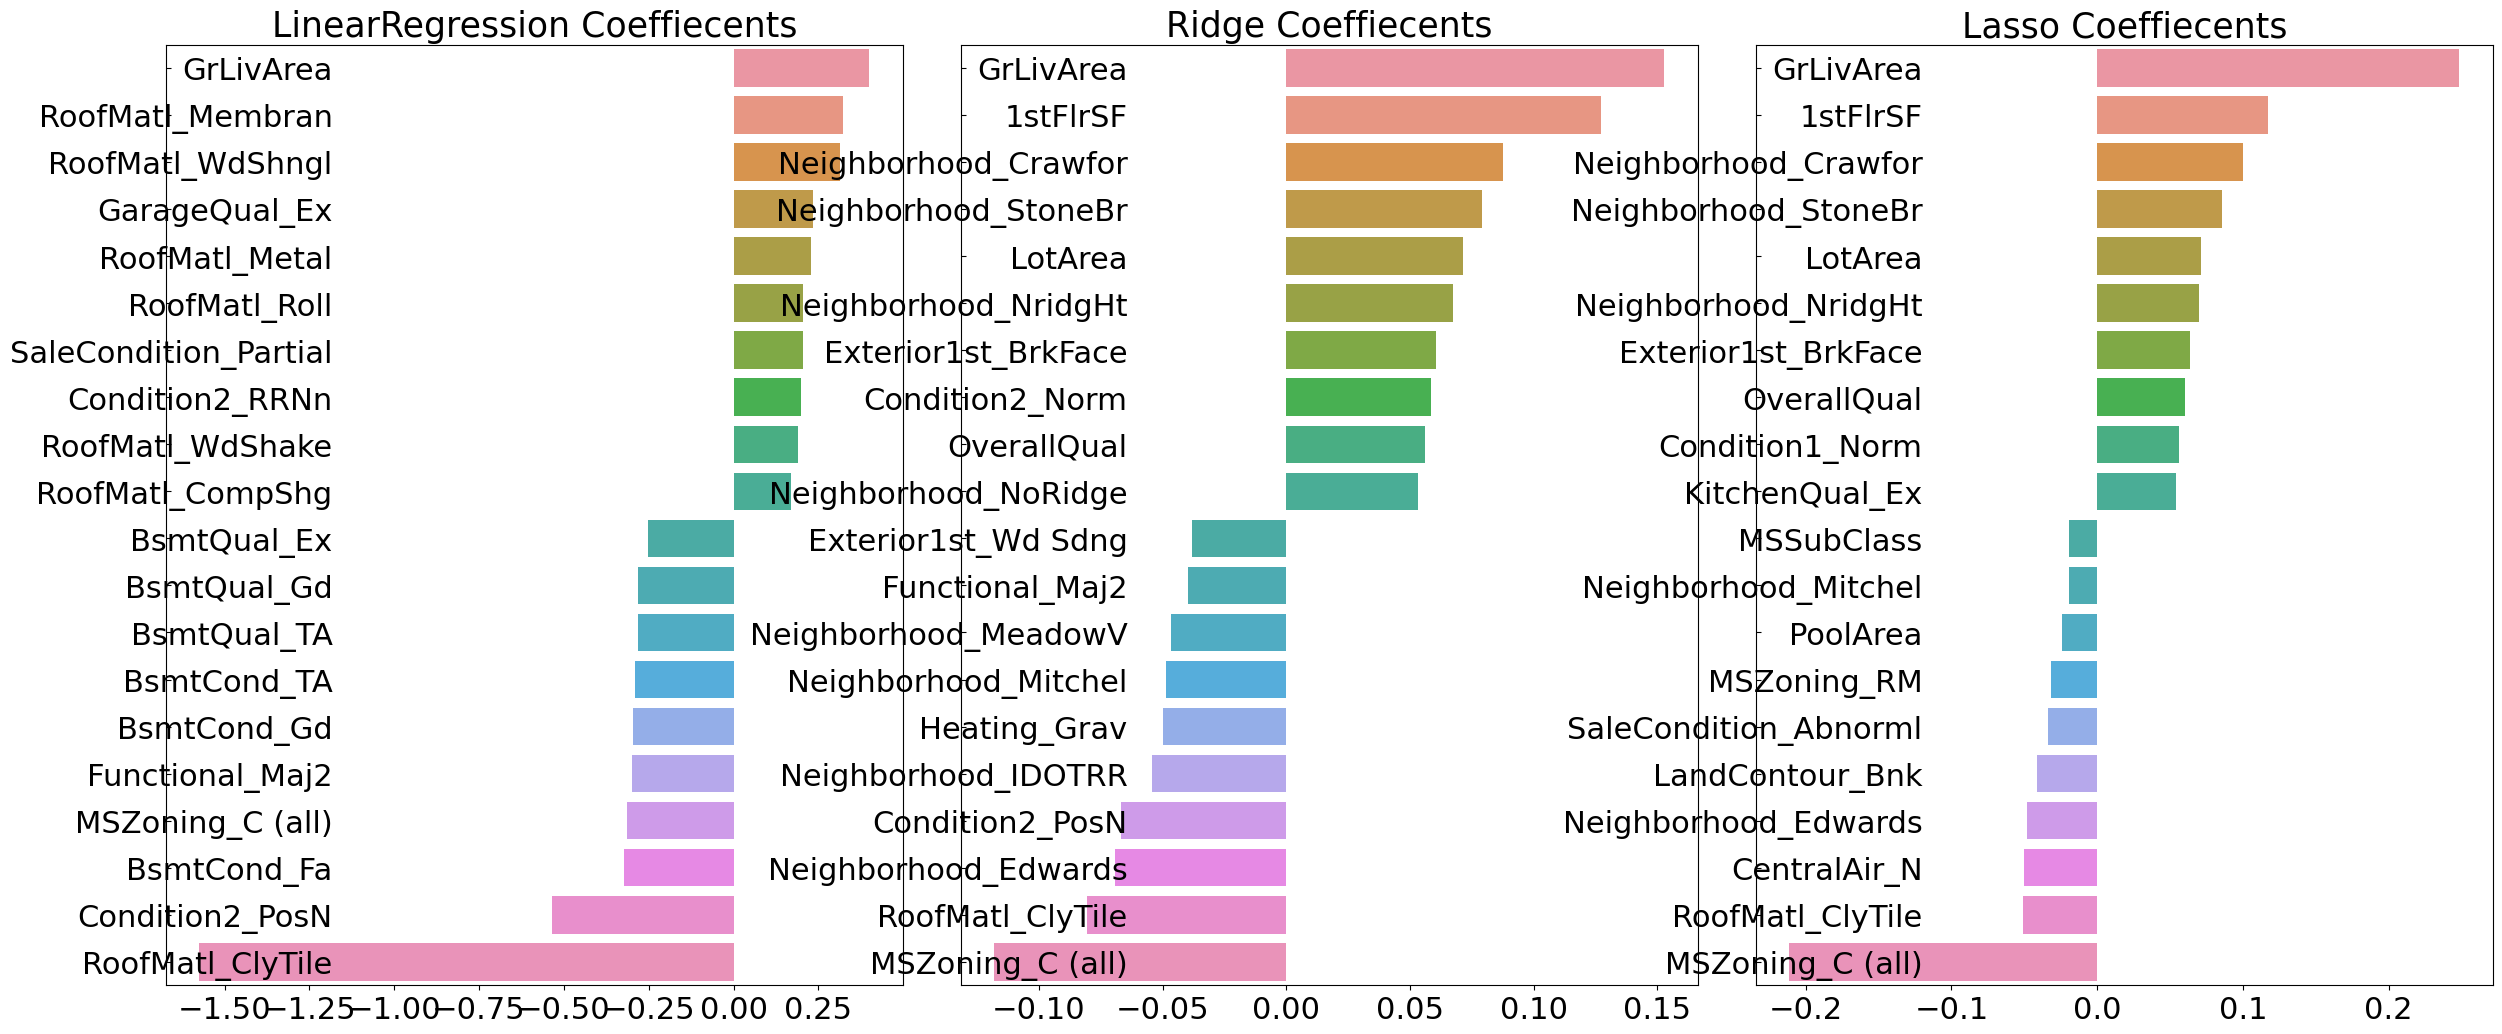

In [143]:
# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 결과  
- 세 모델 모두 GrlivArea(주거공간크기)가 회귀 계수가 가장 높은 피처가 됨
    - 주거공간의 크기가 주택 가격에 미치는 영향이 제일 높다는 의미
    - 상식선에서의 결과가 도출되었다

**세개 모델에서 가장 큰 회귀계수를 가지는 GrLivArea(주거 공간 크기) 피처의 데이터 분포를 살펴봄**

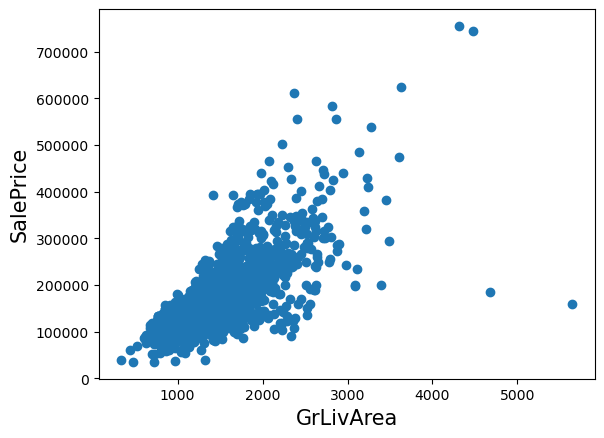

In [144]:
# 타겟값(집값)에 대한 주거공간 크기의 관계를 확인
plt.scatter(x=house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

#### 그래프 해석
- 일반적으로 주거 공간이 큰 집일수록 가격이 비싸기 때문에 양의 상관도가 높음을 알 수있다  
- but. 오른쪽 아패 2개의 데이터는
    - 일반적인 관계에서 많이 벗어나 있음
    - 크기는 큰데 가격은 매우 낮음 => 이상치로 간주하고 삭제

**이상치 데이터 삭제 후 재 학습/예측/평가**

In [151]:
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
# house_df_ohe[cond1 & cond2].index
outlier_index = house_df_ohe[cond1 & cond2].index

In [152]:
print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', house_df_ohe.shape)
# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제. 
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

아웃라이어 레코드 index : [ 523 1298]
아웃라이어 삭제 전 house_df_ohe shape: (1460, 276)
아웃라이어 삭제 후 house_df_ohe shape: (1458, 276)


In [153]:
# house_df_ohe 기반으로 피처/타깃 데이터 세트 다시 생성하고
# 릿지와 라쏘 모델의 최적화 수행

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

In [154]:
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = get_best_params(ridge_reg,ridge_params)
best_lasso = get_best_params(lasso_reg,lasso_params)

Ridge 5 CV 시 최적 RMSE 값: 0.113, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 RMSE 값: 0.1123, 최적 alpha:{'alpha': 0.001}


#### 결론
- 이상치 데이터를 제거 : 예측수치가 크게 향상됨
    - GrLivArea 속성이 회귀 모델에서 차지하는 영향도 크기때문에 이상치 제거가 성능개선에 큰 의미를 가졌음
    
- **회귀에서는 중요한 영향을 미치는 피처를 위주로 이상치 데이터를 찾으면 효과가 큼**

##### tip.
- 보통 머신러닝 프로세스 중에서 데이터 전처리는 알고리즘 적용 수행하기 이전에 진행하지만 완벽하게 전처리를 수행할 필요는 없음
- 대략의 데이터 가공을 진행하고 모델 최적화를 진행 한 후
    - 결과를 기반으로 다시 여러가지 전처리를 진행하는것이 바람직하다

- 이상치를 제거한 데이터 세트를 기반으로 분할된 데이터에 RMSE 수치 및 회귀 계수 시각확

In [155]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.001)

In [156]:
# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.104
Lasso 로그 변환된 RMSE: 0.1


[0.1283402829248523, 0.10359889117940804, 0.1001723101982164]

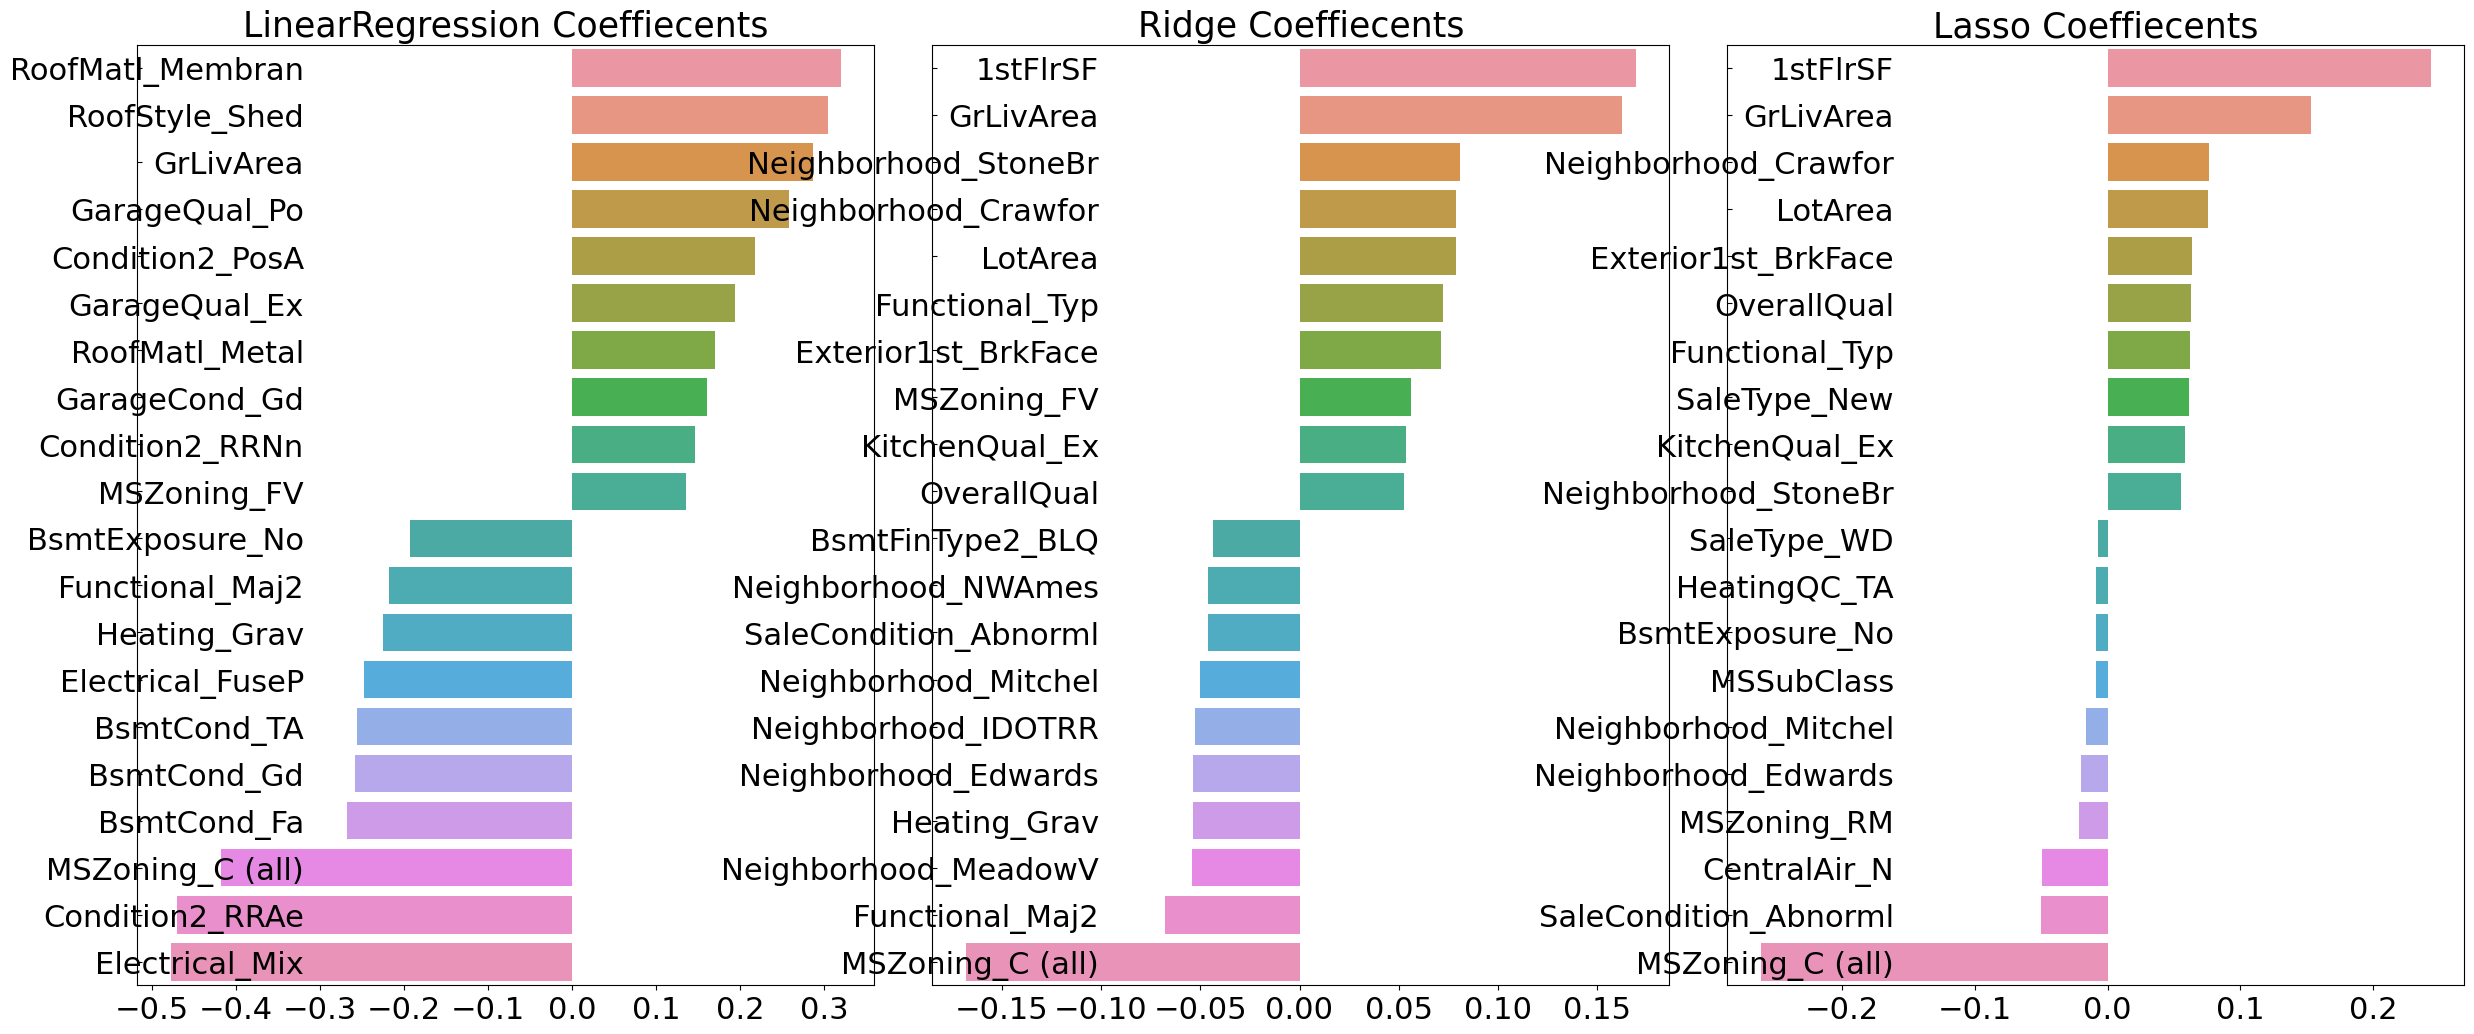

In [157]:
# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 회귀 트리 학습/예측/평가 

- **XGBoost와 LightGBM 학습/예측/평가**
- 좋은 성능의 알고리즘으로 알려져 있음

회귀 트리
- 회귀 함수를 기반으로 하지 않고
- 트리를 기반으로 하는 회귀 방식
- 분류 트리와 유사하지만
- 리프 노드에서 예측 결정값을 만드는 과정에 차이가 있음
- 분류 트리 :  특정 클래스 레이블을 결정
- 회귀 트리 : 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값 계산

CART(Classification And Regression Trees) 기반 알고리즘
- 결정 트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 등 트리 기반 알고리즘은
- 분류뿐만 아니라 회귀도 가능

In [159]:
!pip install xgboost

     --------------------------------------- 89.1/89.1 MB 20.5 MB/s eta 0:00:00


In [161]:
# XGBoost와 LightGBM 모두 수행 시간이 오래 걸릴 수 있는 관계로
# 하이퍼 파라미터 설정을 미리 적용한 상태로
# 5 폴드 세트에 대한 평균 RMSE 값 추출

from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]} #의사결정트리 알고리즘을 몇개 사용할 것이냐?
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = get_best_params(xgb_reg,xgb_params )


XGBRegressor 5 CV 시 최적 RMSE 값: 0.1164, 최적 alpha:{'n_estimators': 1000}


In [ ]:
# !pip install lightgbm

In [163]:
# 이번에는 LightGBM 회귀 트리 적용
from lightgbm import LGBMRegressor
lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05,subsample=0.6,
                         colsample_bytree=0.4, reg_lambda=10,num_leaves=4,
                         n_jobs=-1)
best_lgbm = get_best_params(lgbm_reg, lgbm_params)



LGBMRegressor 5 CV 시 최적 RMSE 값: 0.1175, 최적 alpha:{'n_estimators': 1000}


**트리 회귀 모델의 피처 중요도 시각화**

In [164]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

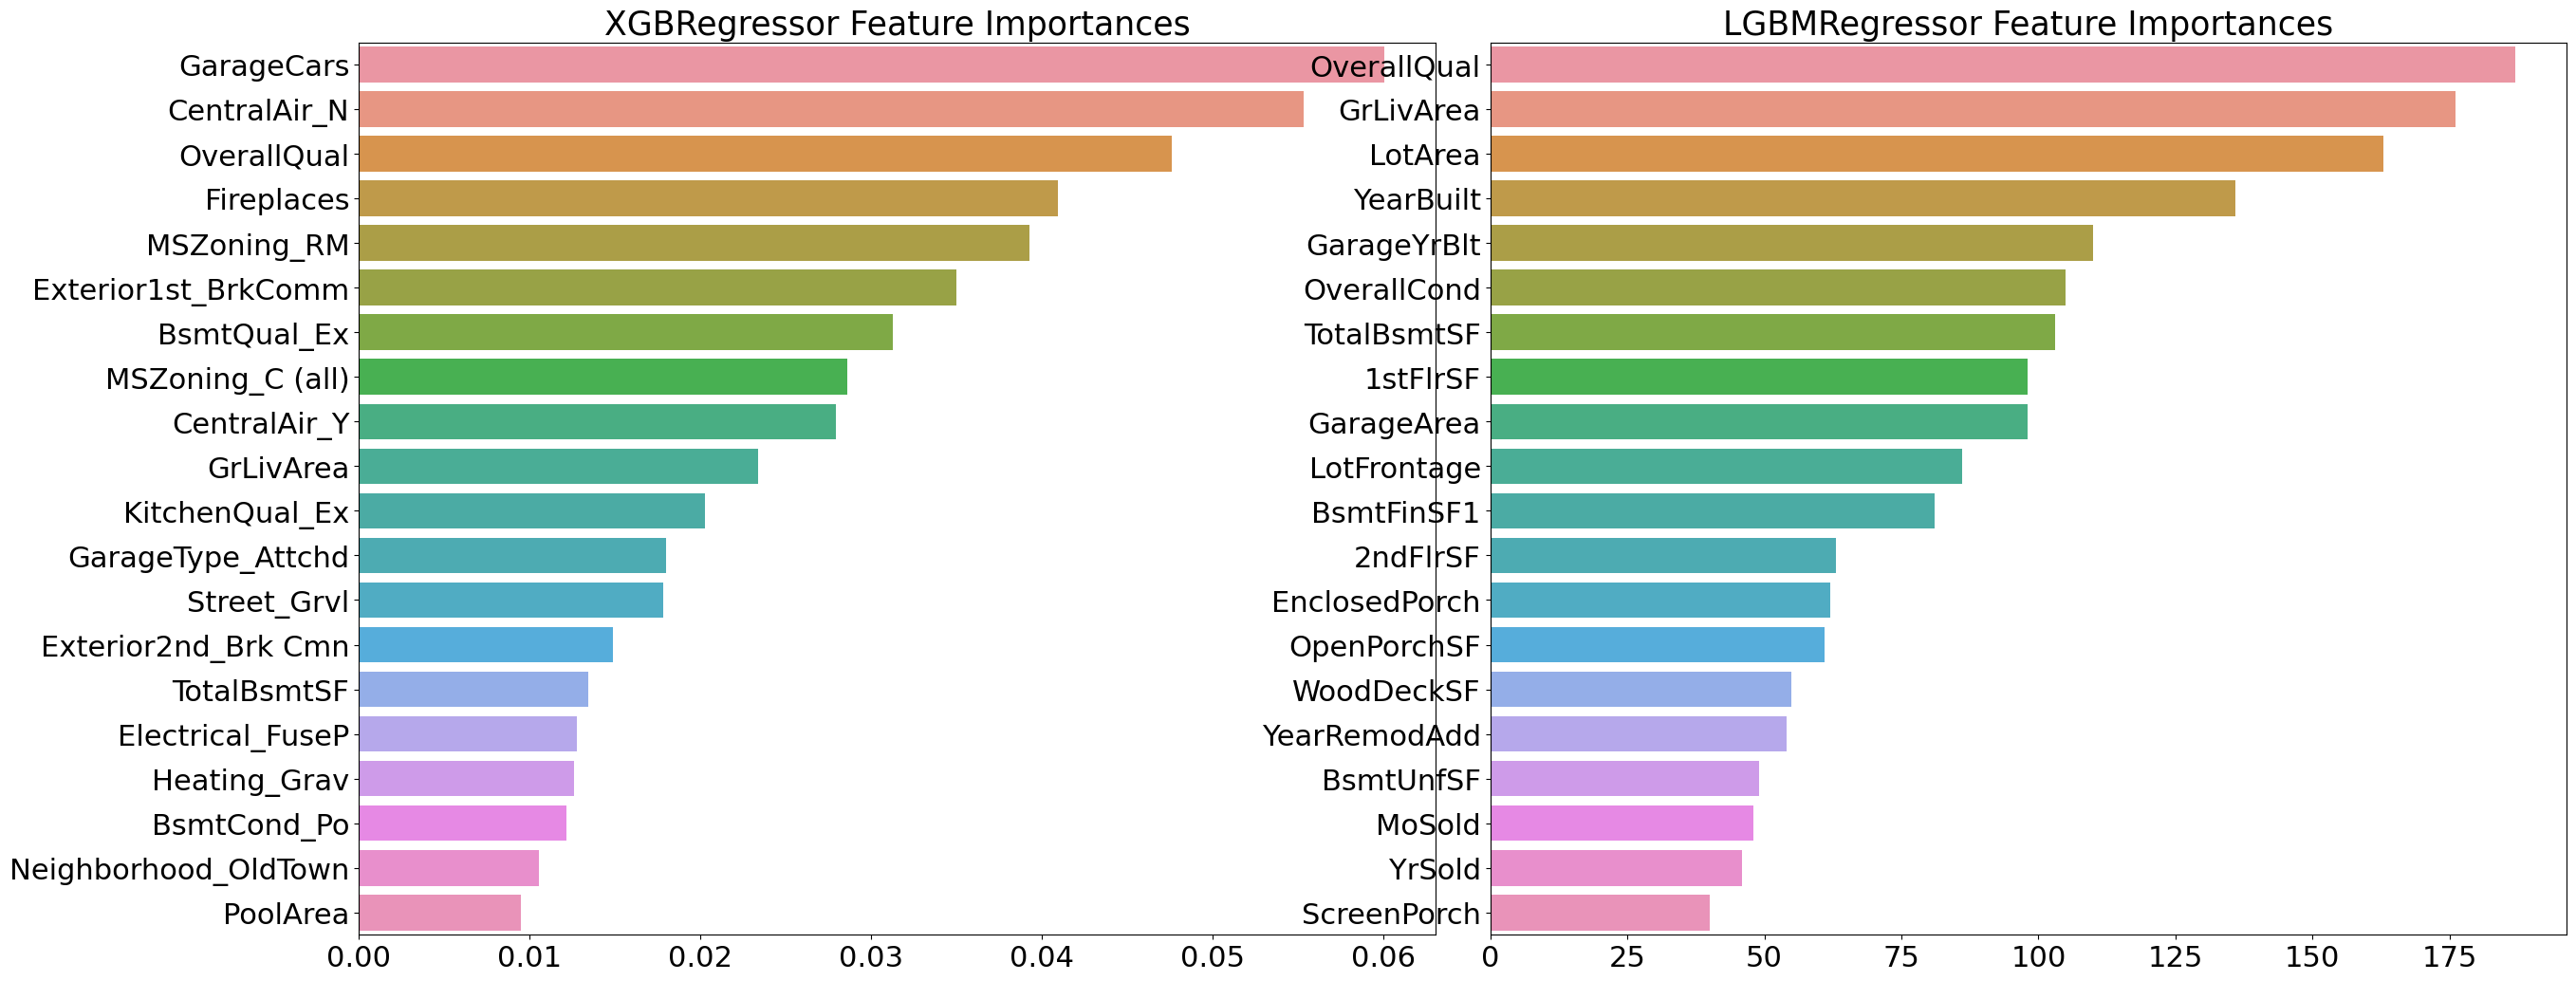

In [165]:
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

### 회귀 모델들의 예측 결과 혼합을 통한 최종 예측

- 개별 회귀 모델의 예측 결과값을 혼합해서 이를 기반으로 최종 회귀값 예측

- ex. 
    - A모델,B모델
    - A모델의 예측값의 40%, B모델의 예측값의 60%를 더해서 최종 회귀값으로 예측
    - A[100, 80, 60], B[120, 80, 50]
    - [100 * 0.4 + 120 * 0.6, 80 * 0.4 + 80 * 0.6, 60 * .4 + 50 * 0.6]

In [166]:
# 최종 혼합 모델과 개별 모델의 RMSE 값 출력하는 함수 생성
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

In [167]:
# 개별 모델 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train,y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)
# 개별모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

In [173]:
# ridge_pred 
# lasso_pred

In [174]:
# 개별 모델 예측값 혼합으로 최종 예측값 도출
# ridge : 40%, lasso : 60%
pred = ridge_pred *0.4 + lasso_pred * 0.6

In [176]:
# pred

In [177]:
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}

#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10008401393966344
Ridge 모델의 RMSE: 0.10359889117940804
Lasso 모델의 RMSE: 0.1001723101982164


### 결과
- 최종 예측 결과를 혼합한 RMSE가 개별 모델보다 성능면에서 약간 개선됨
- 두 모델의 예측을 모두 반영하되 성능이 조금 좋은 쪽에 가중치를 두고 반형한 결고

#### 이번에는 XGBoost와 LightGBM 혼합 (각 50%)

In [178]:
xgb_reg = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

In [179]:
pred = xgb_pred * 0.5 + lgbm_pred * 0.5
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
        
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10267340377090536
XGBM 모델의 RMSE: 0.107286147196175
LGBM 모델의 RMSE: 0.10392491443937421


In [184]:
# lasso_pred

### 결과
- 많은 차이는 아니지만 혼합 예측 결과가 개별모델 RMSE보다 아주 약간 향상됨

## 스태킹 모델을 통한 회귀 예측

**스태킹모델은 회귀에도 적용 가능한 앙상블 모델**

#### 스태킹(stacking)  

- 개별적인 여러 알고리즘(모델)을 서로 결합해 예측 결과를 도출함 
    - 배깅 및 부스팅 방식과 동일
    
- 배깅 및 부스팅과의 차이점
    - **개별알고리즘으로 예측한 예측값을 기반으로**
    - 다시 예측을 수행

#### 수행순서
1. 개별 알고리즘의 예측 결과 데이터 세트를 생성
2. 1번에서 생성된 데이터 세트를 메타 데이터 세트로 만든다
3. 2번에서 생성된 데이터 세트를 별도의 ML 알고리즘(개발자가 선택)으로 최종 학습을 수행하고
4. 테스트 데이터를 기반으로 다시 최종 예측을 수행하는 방식

#### 메타모델 
- 개별 모델을 메타모델이라고 함
- 메타모델의 예측 결과가 최종 모델의 데이터세트로 활용 됨

#### 스태킹 모델 구현 방식
- 두 종류의 모델 필요
1. 개별적인 기반모델
2. 개별 기반 모델의 예측데이터를 학습데이터로 사용하는 최종 모델

#### 스태킹 모델의 핵심 
- 여러 개별 모델의 예측 데이터를
- 각각 스태킹 형태로 결합해 
- **최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것**
    - 사용자 정의 함수로 구현
    - get_stacking_base_datasets() 함수


1. 학습데이터를 활용해서 메타데이터를 생성
    - 학습데이터와 검증데이터를 분리해서 학습데이터로 학습, 검증데이터로 예측
    - 폴딩을 적용해서 5번의 학습, 5번 검증 평균예측값을 사용
2. 테스트데이터를 이용해서 테스트용 메타데이터를 생성
    - 모델은 1번에서 학습한 모델을 이용해서 예측

In [190]:
from sklearn.model_selection import KFold 
#트레인데이터를 학습/검증 세트로 분리하기 위해 필요
from sklearn.metrics import mean_absolute_error

In [206]:
# 개별 기반 모델(1개의 모델) 최종 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n,y_train_n,X_test_n,n_folds) :
    # 지정된 n_folds 값으로 KFold 객체 생성
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=0)
    
    # 최종모델이 사용할 학습 데이터를 위한 초기 구성 - 넘파이배열로 생성
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    
#     print(train_fold_pred)
#     print(test_pred)
#     return 0,0
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
       #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]
        
#         print(train_index)
#         print(valid_index)
        

        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)

        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
#         print(test_pred)

        
    # 테스트 데이터를 폴드세트의 평균으로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, 
    # test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean 

    
    

**기반 개별 모델은 리지, 라소, XGBoost, LightGBM 으로 생성**
- 최종 모델을 라소로 생성하여 학습/예측/평가

In [207]:
# 생성한 함수가 ndarray를 인자로 사용하므로 DF를 ndarray로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

In [214]:
# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [213]:
# ridge_train
# ridge_test
lasso_train
lasso_test

array([[11.63534727],
       [12.2376026 ],
       [12.00690318],
       [11.4520964 ],
       [12.09463225],
       [12.13753212],
       [12.35175269],
       [13.22745391],
       [11.91690457],
       [11.99929991],
       [12.34661365],
       [11.65970588],
       [12.47615655],
       [12.4185058 ],
       [12.1304407 ],
       [12.54792857],
       [12.23022259],
       [11.86186613],
       [12.06293973],
       [12.2940557 ],
       [12.04626971],
       [12.0345419 ],
       [11.60663526],
       [11.32316303],
       [12.30317014],
       [12.37418194],
       [11.87145641],
       [12.971116  ],
       [12.38806991],
       [12.17984128],
       [12.41974678],
       [11.57614739],
       [12.42929764],
       [11.72027192],
       [11.81527142],
       [11.90954302],
       [11.93220236],
       [12.24310468],
       [11.46680028],
       [11.84924613],
       [12.679633  ],
       [12.31828247],
       [11.5103277 ],
       [11.69570927],
       [11.79970466],
       [11

In [215]:
# 각 개별 모델이 반환한 학습용피처 데이터와 테스트용피처 데이터 세트를 결합해서 
# 최종데이터세트 생성 - 메타데이터
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

In [217]:
Stack_final_X_train
Stack_final_X_test

array([[11.66511622, 11.63534727, 11.69674702, 11.6230279 ],
       [12.24545448, 12.2376026 , 12.20613785, 12.22687759],
       [11.97197005, 12.00690318, 11.94118404, 11.9754711 ],
       ...,
       [11.83634316, 11.84260933, 11.83375568, 11.89911575],
       [11.32695211, 11.3850416 , 11.33967876, 11.27293262],
       [12.77506931, 12.78091939, 12.88295078, 12.90166075]])

In [218]:
# 최종 모델은 라쏘 모델을 적용 
# - 위에서 진행했던 모델링 결과가 lasso 성능이 가장 좋았음

meta_model_lasso = Lasso(alpha=0.0005)

# 기반 모델의 예측값을 기반으로 새롭게 만들어진 데이터를 이용 학습/예측/평가
meta_model_lasso.fit(Stack_final_X_train,y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)

In [219]:
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.09819429227086025


### 결과
- 최종적으로 스태킹 회귀 모델을 적용한 결과 
    - 테스트 데이터세트에서 RMSE가 0.098로 위에서 진행한 모델 포함 가장  좋은 성능평가를 보여줌
- 스태킹 모델은 분류와 회귀에서 효과적으로 사용될 수 있는 모델

정리


선형회귀
- 실제값과 예측값의 차이인 오류를 최소로 줄일 수 있는 선형 함수를 찾아서
- 이 선형 함수에 독립변수(피처)를 입력해
- 종속변수(타깃값, 예측값)을 예측하는 것

최적의 선형 함수를 찾는 방법
- 실제값과 예측값 차이의 제곱을해서 계산 후 회기 계수 W를 변수로 하는 비용 함수로 만들고
- 이 비용 함수가 최소화되는 W값을 찾음
- 이 비용 함수를 최소화할 수 있는 방법 : 경사 하강법
- 이러한 비용 함수의 최적화 기법은 머신러닝 전반에 걸쳐서 매우 중요한 개념 중  하나

선형 회귀 과적합 문제 발생 
- 실제값과 예측값의 차이를 최소화하는 것에만 초점을 맞춘 단순 선형 회귀는
- 데이터에 과적합되는 문제 발생 가능성 높음

과적합 문제 해결 --> 규제 도입
- 릿지 : L2 규제 적용
- 라쏘 : L1 규제 적용
- 엘리스틱넷 : L1 + L2 규제
- 일반적으로 선형 회귀는 이들 규제 선형 회귀 많이 사용

로지스틱 회귀
- 선형 회귀를 분류에 적용한 대표적인 모델
- 이름은 회귀이지만 실제로는 분류를 위한 알고리즘
- 선형 함수 대신 시그모이드 함수 도출
- 독립변수(피처)를 시그모이드 함수에 입력해 반환된 결과를
- 확률값으로 변환해서 예측 레이블 결정
- 매우 뛰어난 분류 알고리즘
- 특히, 이진 분류나 희소 행렬로 표현되는 
- 텍스트 기반의 분류에서 높은 예측 성능 보임

회귀 트리
- 선형/비선형 회귀와 같이 최적의 선형/비선형 함수를 찾아내는 대신
- 회귀 트리를 이용해 예측하는 방법도 있음
- 분류를 위해 만들어지 분류 트리와 유사하지만
- 리프 토드에서 예측 결정 값을 만드는 과정에 차이가 있음
- 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값 계산
- 결정트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 모두
- 회귀 트리를 이용해 회귀를 수행하는 방법 제공

선형 회귀 : 왜곡(skew) : 로그 변환 적용
- 선형 모델을 기반으로 하는 선형 회귀는
- 데이터 값의 분포도와 인코딩 방법에 많은 영향을 받을 수 있음
- 데이터 값의 분포도가 정규 분포도 형태를 선호
- 특히 타깃값의 분포도가 정규 분포 형태일 경우 예측 성능 저하 발생하지 않음
- 로그 변환 적용 : 데이터 세트가 왜곡된 데이터 분포를 가질때
- 원-핫 인코딩 : 데이터 세트에 카테고리형 데이터가 있을 경우
    - 레이블 인코딩을 통한 숫자형 변환보다는 원-핫 인코딩 변환해 줘야 함
- 회귀 트리의 경우 인코딩 방식에 크게 영향 받지 않음

결론
- 예제에서 데이터 정제/변환, 선형 회귀/회귀 트리의 최적화를 통해
- 어떻게 회귀 모델을 향상시키는지 실습
- 특히 스태킹 모델을 회귀에 적용해 훌륭한 예측 성능을 도출할 수 있었음